In [1]:
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score, 
                             roc_curve, precision_recall_curve, confusion_matrix, 
                             ConfusionMatrixDisplay)

# **Text Analysis** 

* * *

## Dataset

The following dataset combines SMS and Emails datasets for phishing detection. It is balanced and already preproccessed for text analysis

In [2]:
train_df = pd.concat(
    [
        pd.read_csv('../DATASETS/EXP/TRAIN_SMS.csv'), 
        pd.read_csv('../DATASETS/EXP/TRAIN_EMAILS.csv')
    ], 
    axis=0, 
    ignore_index=True
)

train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df

,text,label
0,hey give old toshiba cs100 early pentium 400mb...,0
1,500 free text msg text ok 80488 call 087187380...,1
2,houston visit doorstep sound like significant ...,0
3,spot deal create enter follow deal sitara hplc...,0
4,hey really want chat text hot 69698 text charg...,1
...,...,...
16103,sl sl misc rant find job java v c make good pr...,0
16104,want new video phone 600 anytime network min 4...,1
16105,monday 09 september 2002 11 13 cet matt sergea...,0
16106,dear v0daf0ne customer 5 00 000 winner guarant...,1


In [3]:
test_df = pd.concat(
    [
        pd.read_csv('../DATASETS/EXP/TEST_SMS.csv'), 
        pd.read_csv('../DATASETS/EXP/TEST_EMAILS.csv')
    ], 
    axis=0, 
    ignore_index=True
)

test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df

,text,label
0,-----BEGIN PGP SIGNED MESSAGE-----\nHash: SHA1...,0
1,FREE entry into our £250 weekly comp just send...,1
2,Wayne E Baisley wrote:\n> There's nothing you ...,0
3,100% Free Porn!\nWhat more can you ask for?\nC...,1
4,Keep my payasam there if rinu brings,0
...,...,...
4024,Dear Customer your pyatm wallet Has been booke...,1
4025,"Mobile Office, AIRTEL LIVE & MMS settings hav...",1
4026,info hpuente @ epelectric . com 915 - 543 - 4333,0
4027,fw : csfb independent power weekly - - issue #...,0


In [4]:
# Solving little issues with missing values
train_df = train_df.dropna()
test_df = test_df.dropna()
print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")

Train dataset shape: (16106, 2)
Test dataset shape: (4029, 2)


Splitting datasets in training and test sets

In [5]:
X_train, X_test, y_train, y_test = train_df['text'], test_df['text'], train_df['label'], test_df['label']

## TF-IDF Vectorizer

TF-IDF vectorizer is a technique for transforming text into numerical vectors that can be used for machine learning or other purposes. It stands for Term Frequency-Inverse Document Frequency, which means that it assigns a weight to each word based on how often it appears in a document and how rare it is across a collection of documents. The purpose of TF-IDF vectorizer is to measure the importance or relevance of a word in a document, and to reduce the impact of common words that do not carry much information. For example, the word "the" is very frequent in English, but it does not tell us much about the topic or meaning of a text. Therefore, TF-IDF vectorizer would give it a low weight compared to a word like "vectorizer", which is less common and more specific.

TF-IDF vectorizer can create features that represent the content and tone of a text, and feed them into a classifier algorithm such as logistic regression, naive Bayes, or support vector machines.

### Hyperparameter optimization with GridSearchCV

GridSearchCV is a cross validation technique included in the scikit learn package. What it does is to run through the different parameters entered in the parameter grid and extract the best values and parameter combinations. Grid Search uses a different combination of all the specified hyperparameters and their values and calculates the performance for each combination and selects the best value for the hyperparameters. This makes the processing time-consuming and expensive based on the number of hyperparameters involved. Along with Grid Search, cross-validation is also performed.

Some of the hyperparameters of TfidfVectorizer that can be optimized with Bayes search are:

- **max_df**: This parameter controls the maximum document frequency for a term to be included in the vocabulary. It can be a fraction between 0 and 1, or an integer representing the absolute count. A lower value of max_df can reduce the noise and dimensionality of the feature matrix by filtering out common terms.

- **ngram_range**: This parameter specifies the range of n-values for different n-grams to be extracted from the text. An n-gram is a sequence of n consecutive words or characters in a text. A larger value of n can capture more information about the word order and context, but it can also increase the number and size of the features.

In [6]:
# Define the Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True)

In [7]:
# Define the vectorizer
vect = TfidfVectorizer(stop_words="english")

# Define multinomial naive bayes classifier
mnb = MultinomialNB()

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', vect), 
    ("mnb", mnb)
])

# Define the parameter search
params = {
    'tfidf__max_df': (0.25, 0.5, 0.75, 1),
    'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3)),
    'mnb__alpha': (1, 0.1, 0.01)
}

# Perform the bayesian search
gs = GridSearchCV(
    estimator=pipeline, 
    param_grid=params, 
    cv=skf, 
    scoring='accuracy', 
    n_jobs=4
)

gs.fit(X_train, y_train)

# Print the best parameters and best score
print("BEST PARAMETERS:")
pprint(gs.best_params_, indent=2)
print(f"\nBEST SCORE: {gs.best_score_:.3f}")

/opt/anaconda3/envs/machine_learning/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


BEST PARAMETERS:
{'mnb__alpha': 0.01, 'tfidf__max_df': 0.25, 'tfidf__ngram_range': (1, 2)}

BEST SCORE: 0.971


In [8]:
# Print best estimators for TF-IDF Vect & Multinomial NB
gs.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.25, ngram_range=(1, 2),
                                 stop_words='english')),
                ('mnb', MultinomialNB(alpha=0.01))])

## Multinomial Naive Bayes Classifier

A multinomial naive bayes classifier is a type of naive bayes classifier that assumes that the features are multinomially distributed. This means that each feature can take one of a finite number of possible values, such as the count or frequency of a word in a document. A multinomial naive bayes classifier is suitable for text classification problems, where the goal is to assign a document to one or more predefined categories based on its content. For example, a multinomial naive bayes classifier can be used to classify news articles into topics such as sports, politics, entertainment, etc.

The purpose of a multinomial naive bayes classifier is to use the Bayes’ theorem to calculate the probability of each category given the features of a document, and then choose the category with the highest probability as the prediction. The Bayes’ theorem states that the posterior probability of a category given the features is proportional to the prior probability of the category multiplied by the likelihood of the features given the category. The naive assumption is that the features are conditionally independent of each other given the category, which simplifies the calculation of the likelihood.

In [9]:
# Create TF-IDF Vectorizer with best hyperparameters found
vect = gs.best_estimator_[0]
# Create Multinomial NB Classifier with best hyperparameters found
mnb = gs.best_estimator_[1]

In [10]:
# get tf-idf matrix for training
train_vect_matrix = vect.fit_transform(X_train)
# transform X_test to tf-idf matrix
test_vect_matrix = vect.transform(X_test)
# fit NB classifier with the matrix
mnb.fit(train_vect_matrix, y_train)

MultinomialNB(alpha=0.01)

Naive Bayes Classifier gives us the following performance evaluation on the test set:

In [11]:
# Predict and evaluate NB classifier
y_pred = mnb.predict(test_vect_matrix)
y_pred_proba = mnb.predict_proba(test_vect_matrix)[:, 1]
print("\n#### RESULTS:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"F1-score: {f1_score(y_test, y_pred):.3f}")


#### RESULTS:
Accuracy: 0.967
Precision: 0.959
Recall: 0.956
F1-score: 0.957


Also, we are going to visualize classifier performance through this plots:

- ROC-AUC curve 
- Precision-Recall curve
- Confusion matrix

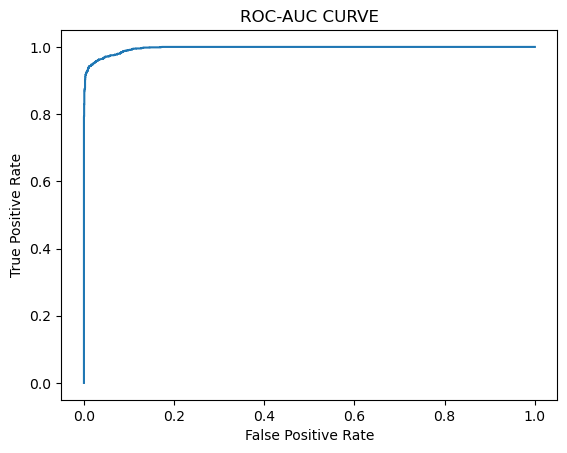

In [12]:
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
#create ROC curve
plt.plot(fpr,tpr)
plt.title('ROC-AUC CURVE')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

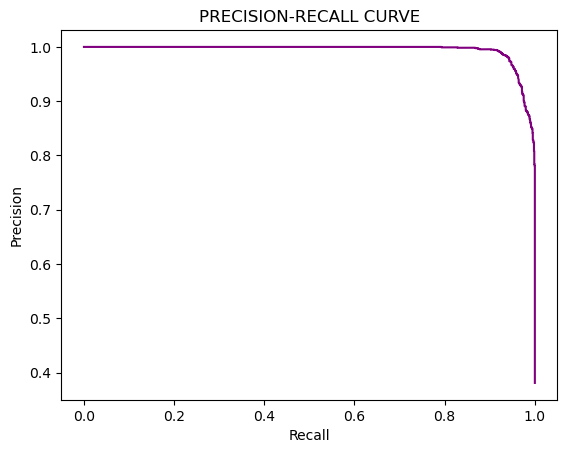

In [13]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
#create Precision-Recall curve
plt.plot(recall, precision, color='purple')
plt.title('PRECISION-RECALL CURVE')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

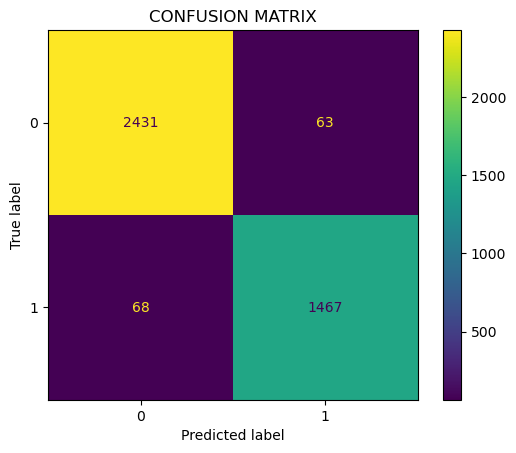

In [14]:
cm = confusion_matrix(y_test, y_pred, labels=mnb.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mnb.classes_)
cm_display.plot()
plt.title('CONFUSION MATRIX')
plt.show()

#### Words Probabilities Analysis

We can extract the probability of each word being classified as phishing or not using `feature_log_prob` function from NB classifier. This gives us a matrix of shape `(n_classes, n_words)`, where class $1$ is phishing and $0$ is benign. Also, TF-IDF vectorizer gives us the features (or words) names it extracted from the train texts.

In [15]:
# Get feature probabilities
class_prob = np.exp(mnb.feature_log_prob_)
# Get feature names, or simply get words
feature_names = vect.get_feature_names_out()

With this information we can plot the top 10 words that have higher probabilities of being classified as phishing or benign. The results will tell us which words are more related with each classification class

In [16]:
benign_prob = class_prob[0] # 0 is for benign
benign_index = np.argsort(benign_prob)[-10:]
benign_words = [feature_names[i] for i in benign_index]
benign_values = [benign_prob[i] for i in benign_index]

phishing_prob = class_prob[1] # 1 is for phishing
phishing_index = np.argsort(phishing_prob)[-10:]
phishing_words = [feature_names[i] for i in phishing_index]
phishing_values = [phishing_prob[i] for i in phishing_index]

In [17]:
pd.Series(data=benign_values, index=benign_words)

net         0.000595
mail        0.000604
http www    0.000639
use         0.000646
www         0.000680
language    0.000782
linux       0.000858
list        0.001036
ect         0.001168
enron       0.001346
dtype: float64

In [18]:
pd.Series(data=phishing_values, index=phishing_words)

order      0.000642
000        0.000663
receive    0.000671
mail       0.000682
money      0.000691
remove     0.000703
company    0.000727
email      0.000897
click      0.000930
free       0.001026
dtype: float64

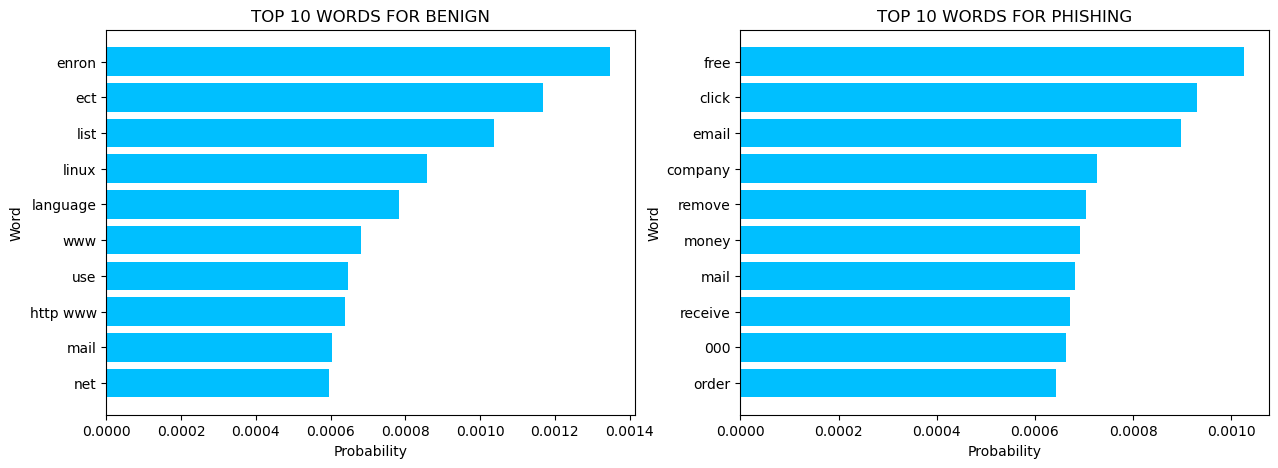

In [19]:
# Plot top 10 words for phishing and benign classification
plt.figure(figsize=(15, 5)) 

plt.subplot(1, 2, 1) 
plt.barh(benign_words, benign_values, color='deepskyblue')
plt.xlabel("Probability")
plt.ylabel("Word")
plt.title('TOP 10 WORDS FOR BENIGN')

plt.subplot(1, 2, 2)
plt.barh(phishing_words, phishing_values, color='deepskyblue')
plt.xlabel("Probability")
plt.ylabel("Word")
plt.title('TOP 10 WORDS FOR PHISHING')

plt.show()

For a nicer visualization of this graphs we can use WordCloud library to create, precisely, a wordcloud, where the most probable words of being classified as phishing or benign are bigger than the others.

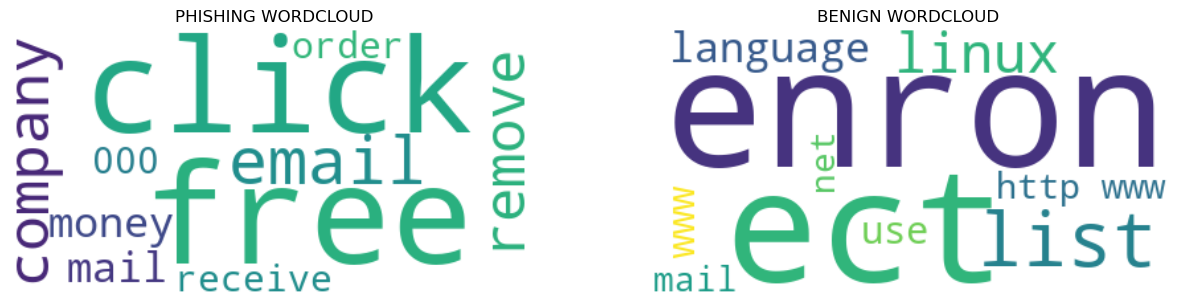

In [20]:
phishing_dict = dict(zip(phishing_words, phishing_values))
benign_dict = dict(zip(benign_words, benign_values))
phishing_cloud = WordCloud(background_color="white").generate_from_frequencies(phishing_dict)
benign_cloud = WordCloud(background_color="white").generate_from_frequencies(benign_dict)

plt.figure(figsize=(15, 5)) 
plt.subplot(1, 2, 1) # Go to the first subplot
plt.imshow(phishing_cloud, interpolation="bilinear")
plt.title('PHISHING WORDCLOUD')
plt.axis('off') 

plt.subplot(1, 2, 2) # Go to the second subplot
plt.imshow(benign_cloud, interpolation="bilinear") 
plt.title('BENIGN WORDCLOUD')
plt.axis('off') 

plt.show() 

#### TF-IDF Analysis

**TF-IDF (term frequency-inverse document frequency)** is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents. The higher is the value, the more relevant the term is in that document. Hence, we'll check TF-IDF averages scores of all features extracted from TF-IDF Vectorizer and sort them in descending order, so we can know which are the most relevant words over all texts corpus.

In [21]:
# Get TF-IDF averages scores from all features
tfidfs = pd.DataFrame.sparse.from_spmatrix(train_vect_matrix, columns=vect.get_feature_names_out())

In [22]:
# Sort in descending order TF-IDF Averages, and get the 50 first values
tfidf_avgs = tfidfs.mean(axis=0).sort_values(ascending=False)[:25]
tfidf_avgs

list           0.010385
enron          0.010042
ect            0.008744
www            0.007951
mail           0.007786
http www       0.007009
linux          0.007003
email          0.006950
use            0.006603
net            0.006528
time           0.006344
make           0.006327
free           0.006288
new            0.006231
message        0.006127
work           0.006126
click          0.006053
00             0.006024
language       0.005975
information    0.005823
like           0.005679
know           0.005648
need           0.005633
10             0.005377
company        0.005372
dtype: Sparse[float64, 0]

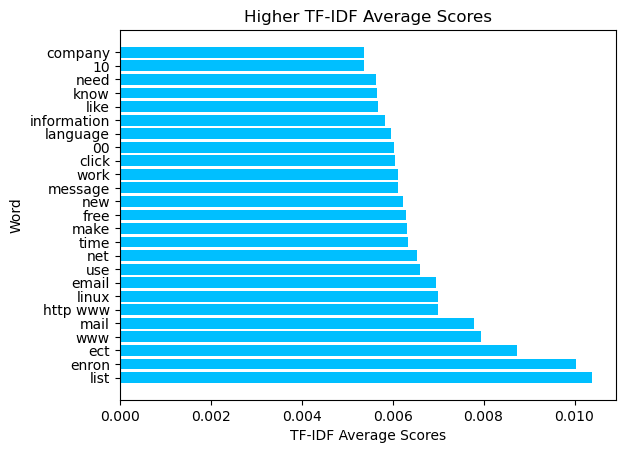

In [23]:
plt.barh(tfidf_avgs.index, tfidf_avgs.values, color='deepskyblue')
plt.xlabel("TF-IDF Average Scores")
plt.ylabel("Word")
plt.title('Higher TF-IDF Average Scores')

plt.show()

**IDF** is a measure of how common or rare a term is across the entire corpus of documents (texts samples). If the word is common and appears in many documents, the idf value (normalized) will approach 0 or else approach 1 if it’s rare. Hence, let's see which are the most common words across all texts samples using this measure.

In [24]:
idfs = vect.idf_ * (1/vect.idf_.max()) # normalize idfs vector between 0 to 1
lower_idfs_indexes = np.argsort(idfs)[:25]
most_common_words = [feature_names[i] for i in lower_idfs_indexes]
most_common_words_idfs = [idfs[i] for i in lower_idfs_indexes]

In [25]:
pd.Series(data=most_common_words_idfs, index=most_common_words)

mail           0.245315
time           0.247569
www            0.248578
use            0.249486
list           0.253378
make           0.255470
information    0.257098
new            0.258087
http www       0.262147
know           0.262713
work           0.263315
like           0.263442
need           0.267630
email          0.268362
subject        0.272036
message        0.274172
10             0.277483
want           0.287883
day            0.289892
include        0.291268
look           0.292578
follow         0.295295
free           0.296085
receive        0.299582
write          0.300729
dtype: float64

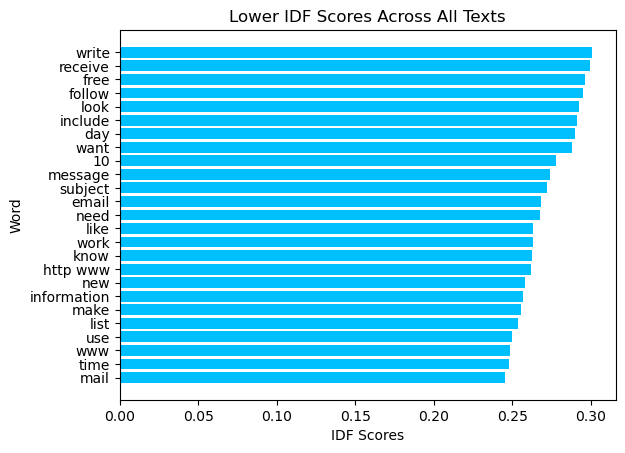

In [26]:
plt.barh(most_common_words, most_common_words_idfs, color='deepskyblue')
plt.xlabel("IDF Scores")
plt.ylabel("Word")
plt.title('Lower IDF Scores Across All Texts')

plt.show()